# Train Federated Model

En este código vamos a entrenar el modelo global (por aprendizaje federado), luego entrenaremos un modelo centralizado (entrenado una vez con todos los datos) y finalmente compararemos ambos modelos.

Archivos necesarios:
* model.py
* test_data.npz
* Todos los modelos previamente entrenados (model_fold#.keras)

### Librerías

In [1]:
# **1. Carga de datos y preprocesamiento**
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt

from model import cnn_model # Nuestro modelo

### Importar datos originales (MNIST)

In [2]:
# Cargar el dataset MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalizar los datos
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Agregar una dimensión para el canal (escala de grises)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

### Importar dataset de prueba

In [3]:
# test_data = np.load('test_data.npz') # Importar dataset de prueba

# # Guardar datos de prueba en sus variables X y Y
# x_test = test_data['x']
# y_test = test_data['y']

# # Mostramos el shape de cada subset
# print(f"Prueba  ---> \t\tX: {x_test.shape}\ty: {y_test.shape}")

### Importar modelos entrenados

In [4]:
t_models = [tf.keras.models.load_model('model_fold1.keras'),
            tf.keras.models.load_model('model_fold2.keras'),
            tf.keras.models.load_model('model_fold3.keras'),
            tf.keras.models.load_model('model_fold4.keras'),
            tf.keras.models.load_model('model_fold5.keras')]

### Modelo CNN

In [5]:
cnn_model = cnn_model.model()
cnn_model.summary()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

### Definición de Modelos Federados

Las estrategias de agregación que utilizaremos para crear el modelo global son las siguientes:

a) Promedio simple (FedAvg)

b) Mediana (Krum)

c) Promedio ponderado por performance

In [6]:
# Promedio simple (FedAvg)
def fedavg_model(models):
  global_weights = []
  for layer_index in range(len(models[0].get_weights())):
    layer_weights = [model.get_weights()[layer_index] for model in models]
    mean_weights = np.average(layer_weights, axis=0)  # Usando la medi
    global_weights.append(mean_weights)

  global_model = cnn_model
  global_model.set_weights(global_weights)
  return global_model

def krum_model(models):
  global_weights = []
  for layer_index in range(len(models[0].get_weights())):
    layer_weights = [model.get_weights()[layer_index] for model in models]
    median_weights = np.median(layer_weights, axis=0)  # Usando la medi
    global_weights.append(median_weights)

  global_model = cnn_model
  global_model.set_weights(global_weights)
  return global_model


def fedavg_weighted_performance(models, model_accuracies):
  global_weights = []
  total_accuracy = sum(model_accuracies)  # Calcular la precisión total de todos los modelos

  for layer_index in range(len(models[0].get_weights())):
    layer_weights = [model.get_weights()[layer_index] for model in models]

    # Calcular pesos ponderados por precisión para cada modelo
    weighted_layer_weights = [layer_weights[i] * (model_accuracies[i] / total_accuracy) for i in range(len(models))]

    # Sumar los pesos ponderados de la capa
    mean_weights = sum(weighted_layer_weights)
    global_weights.append(mean_weights)

  global_model = cnn_model
  global_model.set_weights(global_weights)

  # Compilar el modelo global con FedAdam
  global_model.compile(optimizer=tf.keras.optimizers.AdamW(),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

  return global_model


# Accuracies de cada modelo
model_accuracies = []
for model in t_models:
  _, accuracy = model.evaluate(x_test, y_test, verbose=0)
  model_accuracies.append(accuracy)




# Construcción de modelos federados
# a) Promedio simple
model_fedavg = fedavg_model(t_models)
# b) Mediana
model_krum = krum_model(t_models)
# Promedio ponderado por performance
model_weighted_avg = fedavg_weighted_performance(t_models, model_accuracies)

I0000 00:00:1746395027.724196 17053492 service.cc:152] XLA service 0x3258fe660 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746395027.724208 17053492 service.cc:160]   StreamExecutor device (0): Host, Default Version
2025-05-04 15:43:47.760097: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746395028.010827 17053492 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


### Entrenamiento de modelo centralizado

In [7]:
def train_local_model(model, x_train, y_train, x_test, y_test, epochs=20, save_name="model_trained"):
    history = model.fit(x_train, y_train, epochs=epochs, verbose=1, validation_data=(x_test, y_test))

    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return model

    model = train_local_model(cnn_model, x_train, y_train, x_test, y_test)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.8954 - loss: 0.3718 - val_accuracy: 0.9819 - val_loss: 0.0568
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9679 - loss: 0.1069 - val_accuracy: 0.9864 - val_loss: 0.0469
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9716 - loss: 0.0912 - val_accuracy: 0.9868 - val_loss: 0.0402
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9766 - loss: 0.0790 - val_accuracy: 0.9886 - val_loss: 0.0358
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9760 - loss: 0.0790 - val_accuracy: 0.9876 - val_loss: 0.0356
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9779 - loss: 0.0701 - val_accuracy: 0.9897 - val_loss: 0.0310
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9793 - loss: 0.0681 - val_accuracy: 0.9894 - val_loss: 0.0289
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9802 - loss: 0

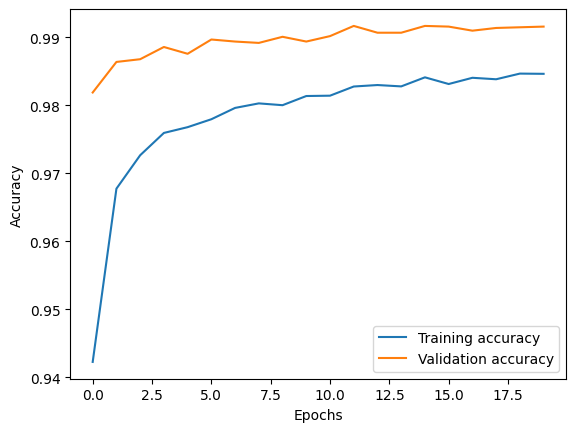

In [8]:
centralized_model = train_local_model(cnn_model, x_train, y_train, x_test, y_test)

### Evaluación y comparación de modelos federado y centralizado

In [9]:
# Modelos federados
_, fedavg_acc = model_fedavg.evaluate(x_test, y_test, verbose=1)
_, krum_acc = model_krum.evaluate(x_test, y_test, verbose=1)
_, weighted_avg_acc = model_weighted_avg.evaluate(x_test, y_test, verbose=1)
# Modelo centralizado
_, centralized_acc = centralized_model.evaluate(x_test, y_test, verbose=1)

print(f"\n\nPrecisión del modelo federado - Promedio Simple: {fedavg_acc:.4f}")
print(f"Precisión del modelo federado - Mediana: {krum_acc:.4f}")
print(f"Precisión del modelo federado - Promedio Ponderado por performance: {weighted_avg_acc:.4f}")
print(f"Precisión del modelo centralizado: {centralized_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9905 - loss: 0.0280
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9905 - loss: 0.0280
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9905 - loss: 0.0280
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9905 - loss: 0.0280


Precisión del modelo federado - Promedio Simple: 0.9916
Precisión del modelo federado - Mediana: 0.9916
Precisión del modelo federado - Promedio Ponderado por performance: 0.9916
Precisión del modelo centralizado: 0.9916


### Visualización de resultados

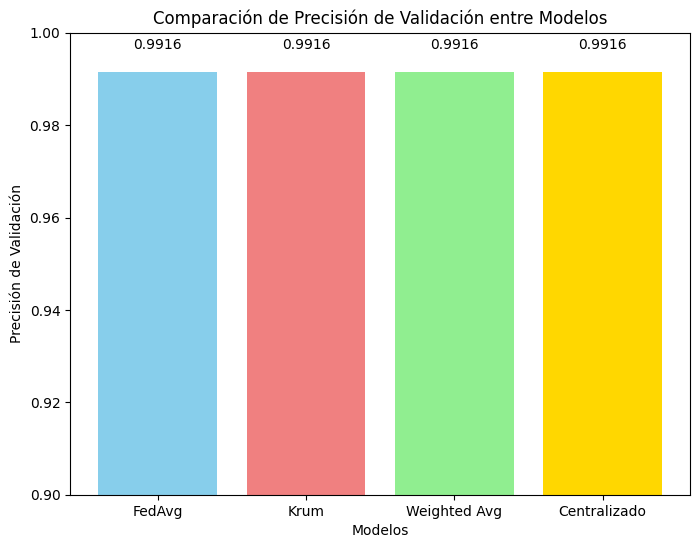

In [10]:

# Datos de precisión para cada modelo
models = ['FedAvg', 'Krum', 'Weighted Avg', 'Centralizado']
accuracies = [fedavg_acc, krum_acc, weighted_avg_acc, centralized_acc]

# Plot
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.xlabel('Modelos')
plt.ylabel('Precisión de Validación')
plt.title('Comparación de Precisión de Validación entre Modelos')

# Agregar valores encima de cada barra
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center')

plt.ylim(0.9,1)
plt.show()


**Classification reports**

In [11]:
y_pred_fedavg = model_fedavg.predict(x_test)
y_pred_fedavg_classes = np.argmax(y_pred_fedavg, axis=1)
print("\n\n\n########## Classification Report de FedAvg Model:\n")
print(classification_report(y_test, y_pred_fedavg_classes))

y_pred_krum = model_krum.predict(x_test)
y_pred_krum_classes = np.argmax(y_pred_krum, axis=1)
print("\n\n\n########## Classification Report de Krum Model:\n")
print(classification_report(y_test, y_pred_krum_classes))

y_pred_weighted_avg = model_weighted_avg.predict(x_test)
y_pred_weighted_avg_classes = np.argmax(y_pred_weighted_avg, axis=1)
print("\n\n\n########## Classification Report de Weighted Average Model:\n")
print(classification_report(y_test, y_pred_weighted_avg_classes))

y_pred_centralized = centralized_model.predict(x_test)
y_pred_centralized_classes = np.argmax(y_pred_centralized, axis=1)
print("\n\n\n########## Cnlassification Report de Centralized Model:\n")
print(classification_report(y_test, y_pred_centralized_classes))


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step



########## Classification Report de FedAvg Model:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       1.00      1.00      1.00      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step



########## Classification Report de Krum Model:

              precision    recall  f1-score   support